In [91]:
# Importing the libraries
import numpy as np
import pandas as pd


import scipy.stats as stats
from statsmodels.formula.api import ols


After meeting with Krzysztof, we decided that statistical tests would only be performed to compare between GDM and non-GDM population in BiB. Comparing BiB with NHS dataset led to unexpected results, possibly due to large difference in sample size and due to the data being collected at very different points in time (BiB collection 2007-2011 and NHS collected 2020-2022).


Therefore, it is decided that:
- in the case of equal variance, a t-test would be performed. 
- And in the case of unequal variance, a welsh test would be performed.

In [2]:
# get datasets

bib = pd.read_csv('BiBFullDataset.csv')

# create new dataframe with non-GDM women only
bib_gdm = bib[bib['gdm'] == 'Yes']
bib_nonGdm = bib[bib['gdm'] == 'No']

In [28]:
def constructDataFrame(feature):
    import pandas as pd
    # load data file
    df = pd.concat([bib_gdm[feature], bib_nonGdm[feature]], axis=1, keys=['bib-GDM', 'bib-nonGDM'])
    # reshape the d dataframe suitable for statsmodels package 
    df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['bib-GDM', 'bib-nonGDM'])

    # replace column names
    df_melt.columns = ['index', 'groups', 'value']
    
    df_melt = df_melt.dropna()
    return df, df_melt

# Test Assumptions

## 1. Normal Distribution

Visually - Checking for normal distribution using visual approaches such as residual plots (e.g. QQ-plots) and histograms.

- QQ plot:
If the standardized residuals lie around the 45-degree line, it suggests that the residuals are approximately normally distributed

In [98]:
def QQPlot(res):
    # QQ-plot
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    # res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
    sm.qqplot(res.anova_std_residuals, line='45')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.show()

- Histogram:
In the histogram, if the distribution looks approximately normal, this suggests that residuals are approximately normally distributed

In [99]:
def histogram(res):
    import matplotlib.pyplot as plt
    # histogram
    plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
    plt.xlabel("Residuals")
    plt.ylabel('Frequency')
    plt.show()

In [136]:
def boxplot(df_melt):
    # generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
    # easily detect the differences between different treatments
    import matplotlib.pyplot as plt
    import seaborn as sns
    ax = sns.boxplot(x='groups', y='value', data=df_melt, color='#99c2a2')
    #ax = sns.swarmplot(x="dataset", y="value", data=df_melt, color='#7d0013')
    plt.show()

Using statistical test

Shapiro-Wilk test can be used to check the normal distribution of residuals. Null hypothesis: data is drawn from normal distribution.

In [86]:
# Shapiro-Wilk test can be used to check the normal distribution of residuals. 
# Null hypothesis: data is drawn from normal distribution.
# If p value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution.

def shapiro(df_melt):
    import scipy.stats as stats
    
    # Ordinary Least Squares (OLS) model
    model = ols('value ~ C(groups)', data=df_melt).fit()

    w, pvalue = stats.shapiro(model.resid)
    print(pvalue)
    return (pvalue)

## 2. Homogeneity of variances (Equal Variances)

If the data is drawn from normal distribution, use Bartlett’s/ Levenes test to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances.

Levene’s test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [88]:
# Levene’s test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

def levene(df_melt):
    # if you have a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
    from bioinfokit.analys import stat 
    res = stat()
    res.levene(df=df_melt, res_var='value', xfac_var='groups')
    #print(res.levene_summary)
    df = res.levene_summary
    return (df.iloc[2]['Value'])

# Statistical Tests: ANOVA, t-test and Welch's t-test

In [110]:
def ANOVA(df, df_melt):
    import scipy.stats as stats
    # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
    fvalue, pvalue = stats.f_oneway( df['bib-GDM'].dropna(), df['bib-nonGDM'].dropna())
    #print(fvalue, pvalue)

    # get ANOVA table as R like output
    import statsmodels.api as sm
    from statsmodels.formula.api import ols

    # Ordinary Least Squares (OLS) model
    model = ols('value ~ C(groups)', data=df_melt).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    #anova_table
    
    # ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
    from bioinfokit.analys import stat
    res = stat()
    res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(groups)')
    #res.anova_summary
    return res

In [77]:
def ttest(feature):
    statistics, pvalue = stats.ttest_ind(bib_gdm[feature].dropna(), bib_nonGdm[feature].dropna())
    print(pvalue)
    return pvalue


Welch’s t-test is a nonparametric univariate test that tests for a significant difference between the mean of two unrelated groups. It is an alternative to the independent t-test when there is a violation in the assumption of equality of variances.

In [78]:
def welch_ttest(feature):
    statistics, pvalue = stats.ttest_ind(bib_gdm[feature].dropna(), bib_nonGdm[feature].dropna(), equal_var = False)
    print(pvalue)
    return pvalue

In [129]:
def statsPipeline(feature):
    print("RUNNING TESTS FOR " + feature)
    
    # generate dataframe
    df, df_melt = constructDataFrame(feature)
    
    # check normality of data
    #shapiro_pvalue = shapiro(df_melt)
    # If shapiro p value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution.
    #if (shapiro_pvalue>0.05):
    #    print(feature + ": data has a normal distibution")
    #else:
    #    print(feature + ": data does NOT have a normal distibution")
        
    
    # Do anova test to get res
    res = ANOVA(df, df_melt)
    # normal distribution
    QQPlot(res)
    histogram(res)
    boxplot(df_melt)
    
    
    # check variance using levene test
    levene_pvalue = levene(df_melt)
    
    # If levene p value is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.
    # therefore we perform a t-test
    # otherwise perform a welch's t-test
    if (levene_pvalue>=0.05):
        print("Equal variances, t-test will be performed")
        ttest_pvalue = ttest(feature)
        # If ttest p value is  significant, we conclude that there is a significant difference in the feature between GDM and non-GDM group
        if (ttest_pvalue<0.05):
            print(feature + ": significant")
        else:
            print(feature + ":non-significant")
            
    # If levene p value is significant, we accept the null hypothesis and conclude that treatments have non-equal variances.
    # therefore we perform a welsh test
    else:
        print("Non-equal variances, Welch's t-test will be performed")
        welch_pvalue = welch_ttest(feature)
        # If welsh test p value is  significant, we conclude that there is a significant difference in the feature between GDM and non-GDM group
        if (welch_pvalue<0.05):
            print(feature + ": significant")
        else:
            print(feature + ": non-significant")
            
    
    print("=======================================================")


## Run Tests

RUNNING TESTS FOR maternalAge


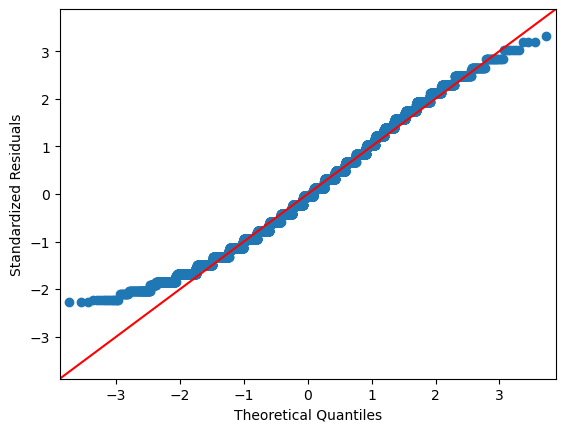

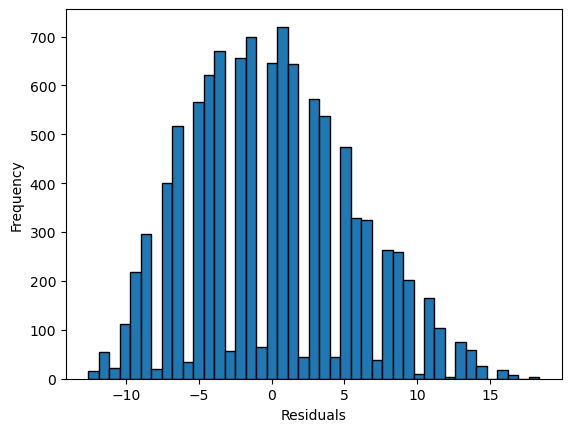

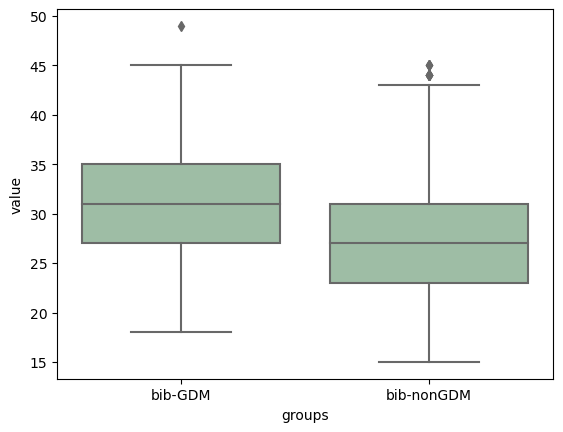

Equal variances, t-test will be performed
1.6626307508269346e-61
maternalAge: significant
RUNNING TESTS FOR bookingWeight


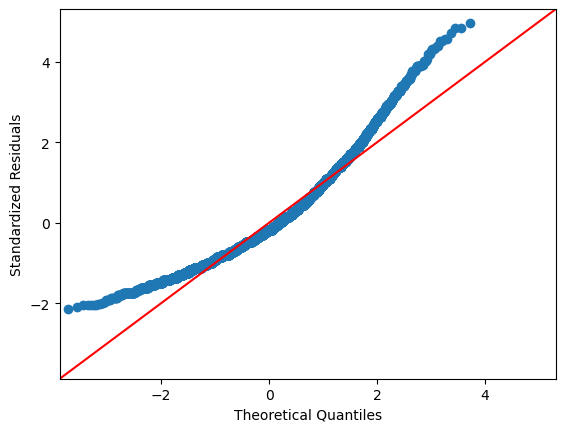

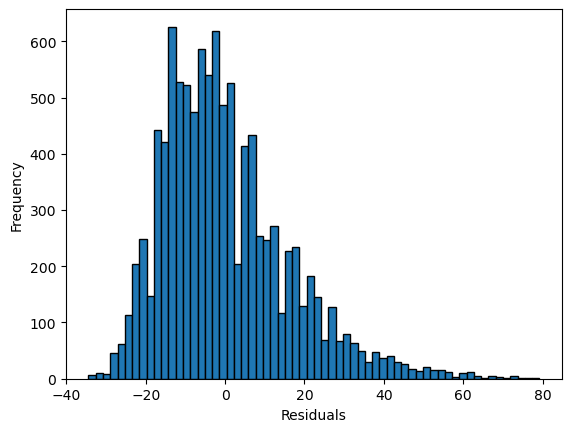

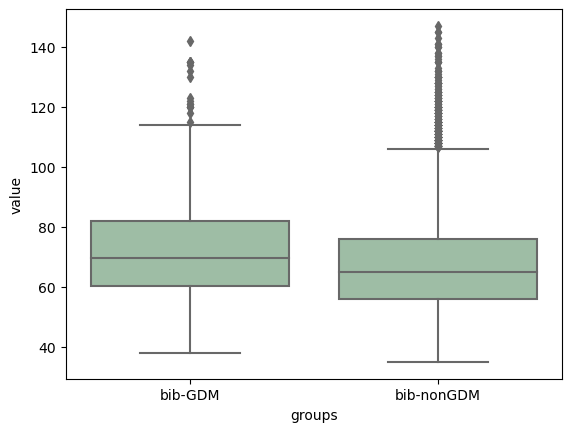

Non-equal variances, Welch's t-test will be performed
1.31953912640858e-13
bookingWeight: significant
RUNNING TESTS FOR bookingBMI


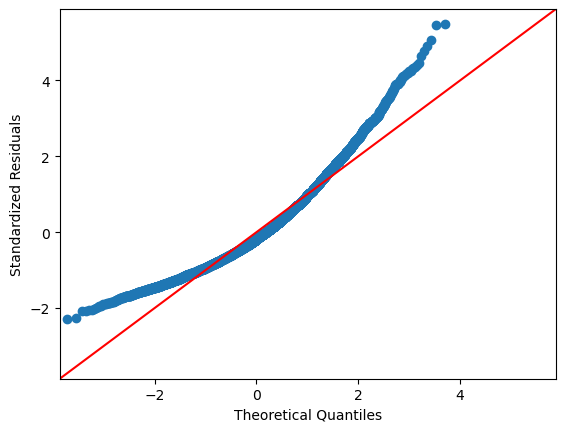

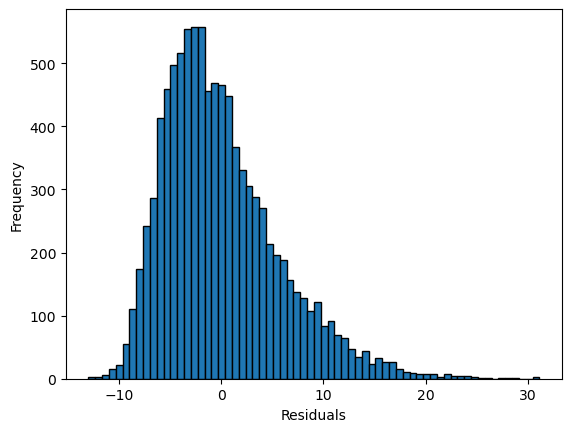

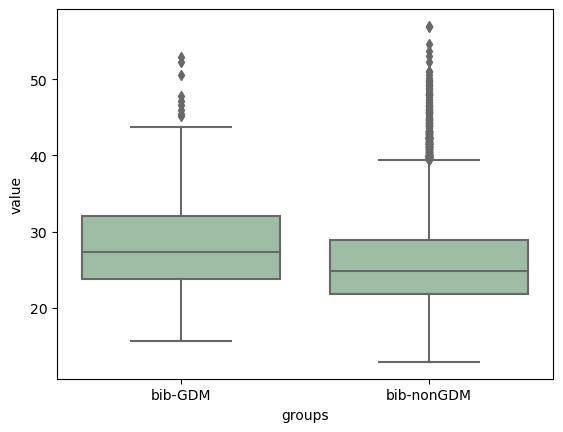

Non-equal variances, Welch's t-test will be performed
3.493645181882299e-26
bookingBMI: significant
RUNNING TESTS FOR maternalHeight


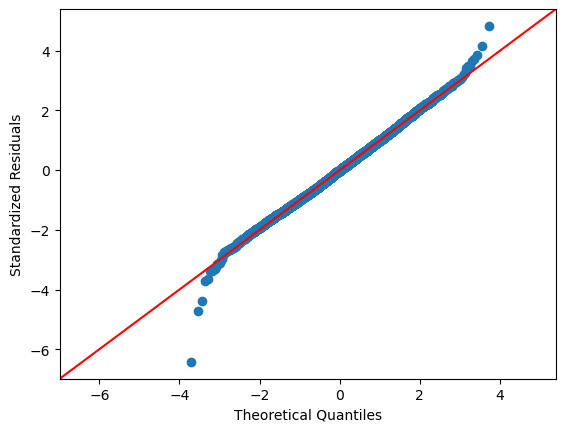

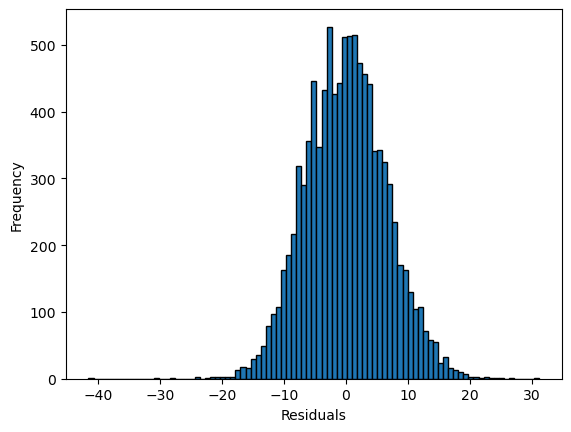

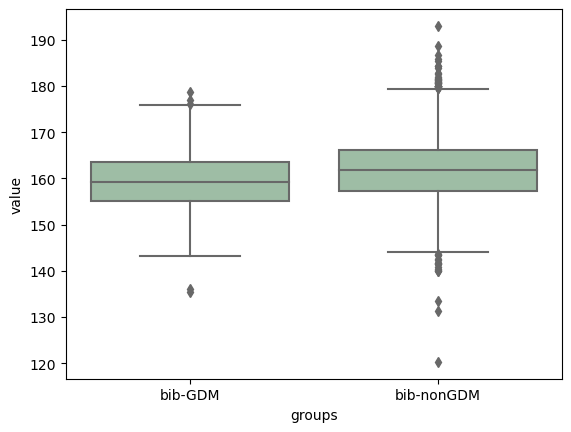

Equal variances, t-test will be performed
7.709400157159882e-21
maternalHeight: significant
RUNNING TESTS FOR thirdTrimesterWeight


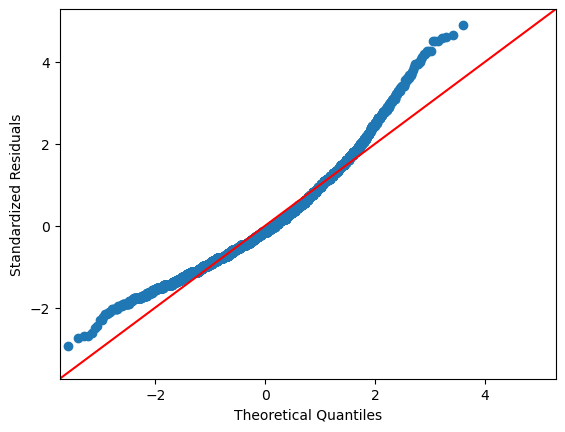

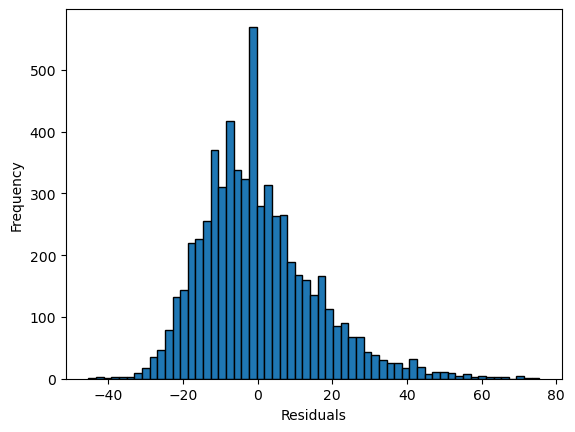

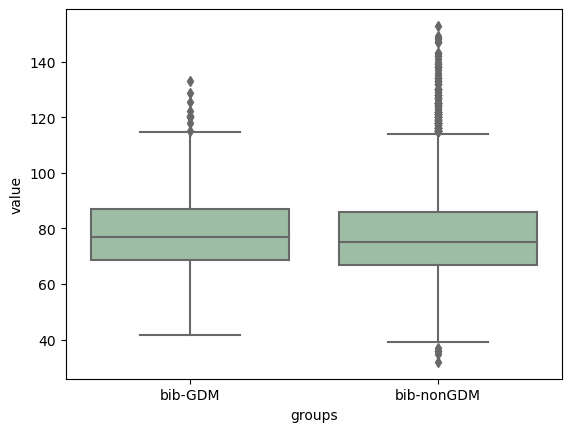

Equal variances, t-test will be performed
0.03466538628441106
thirdTrimesterWeight: significant
RUNNING TESTS FOR fastingGlucose


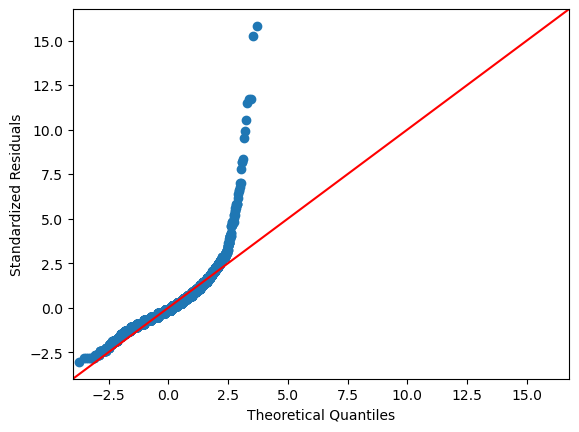

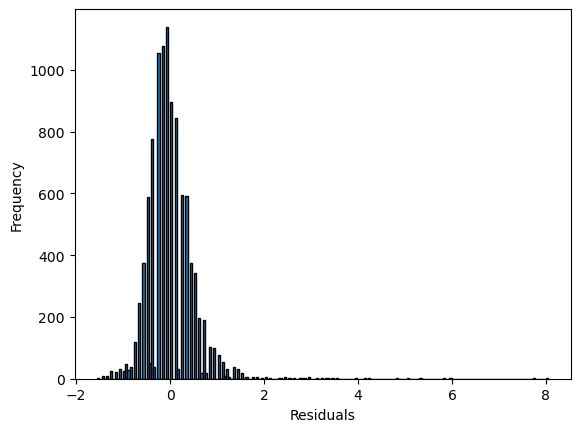

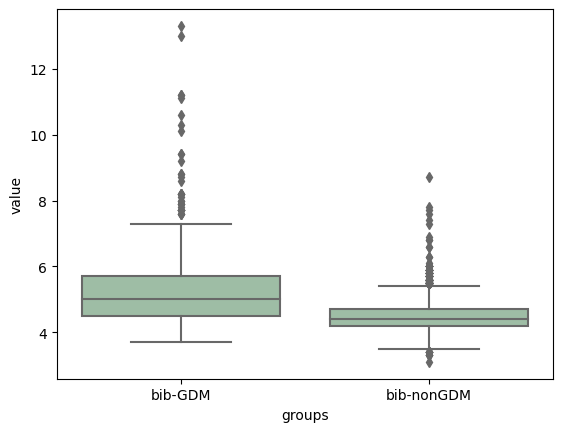

Non-equal variances, Welch's t-test will be performed
5.281075159421932e-74
fastingGlucose: significant
RUNNING TESTS FOR postGlucose


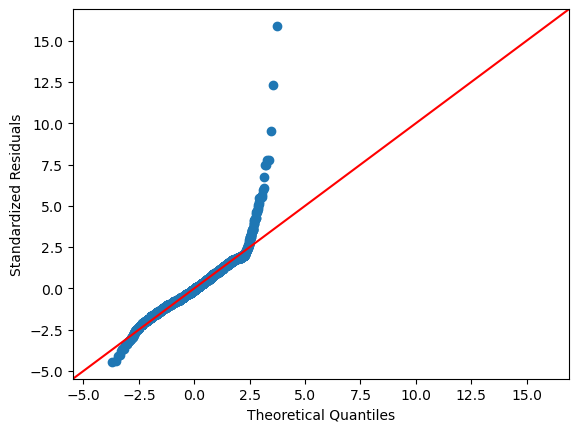

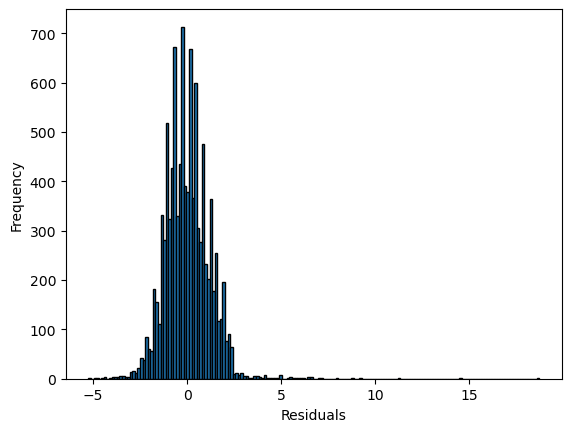

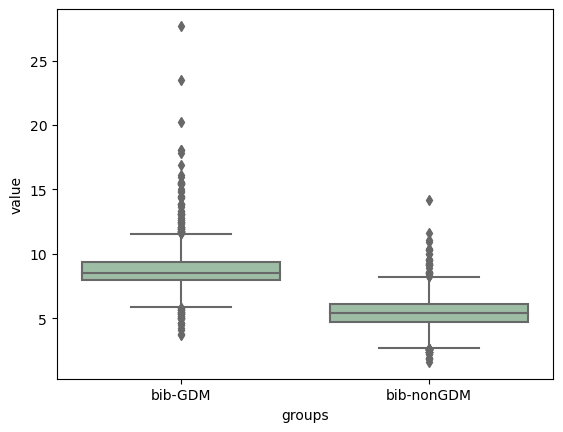

Non-equal variances, Welch's t-test will be performed
6.571787864543375e-259
postGlucose: significant
RUNNING TESTS FOR meanAbdomCirc


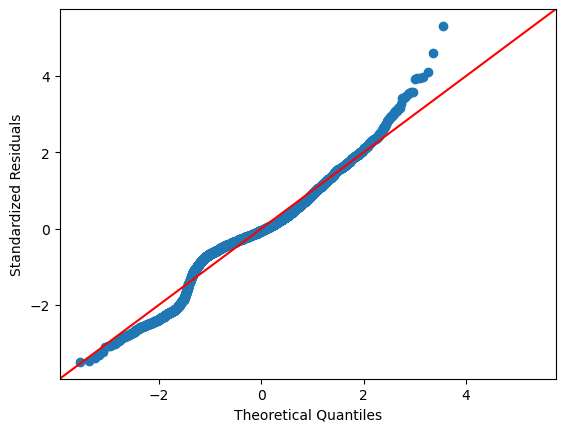

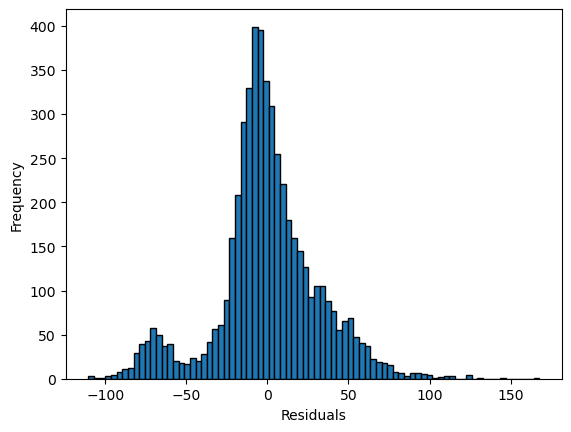

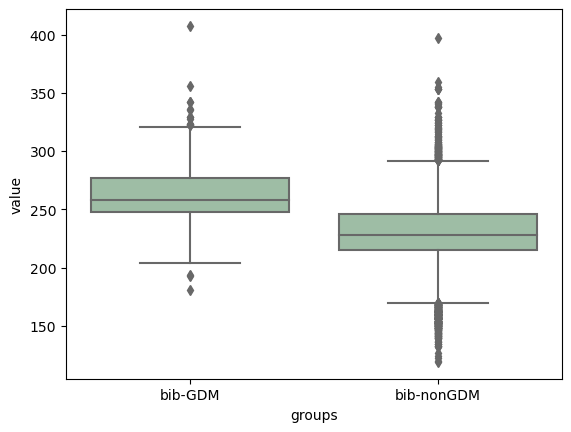

Non-equal variances, Welch's t-test will be performed
3.424061979322598e-183
meanAbdomCirc: significant
RUNNING TESTS FOR maxAbdomCirc


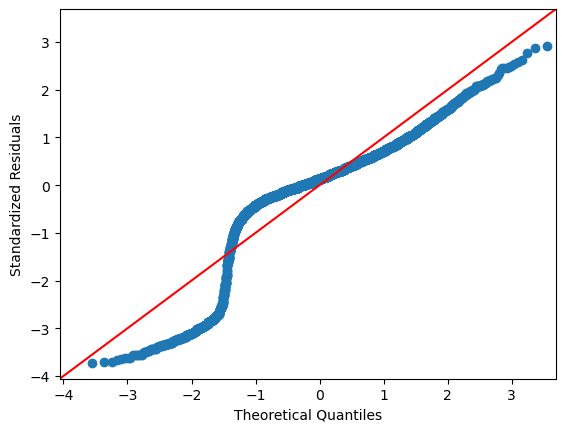

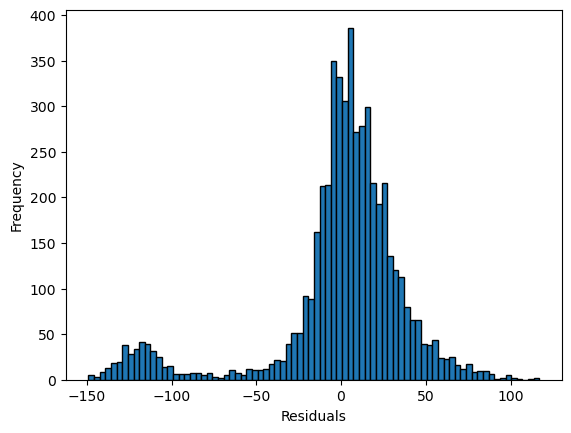

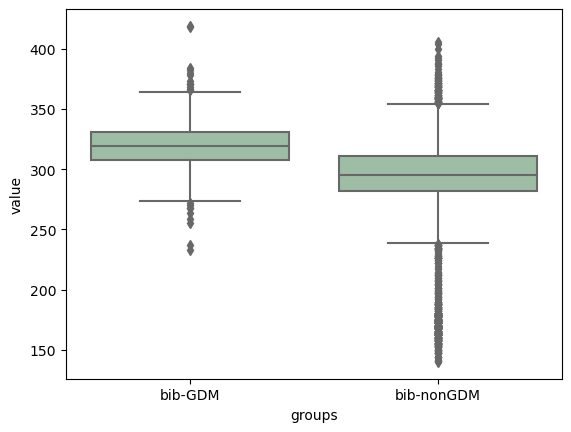

Non-equal variances, Welch's t-test will be performed
6.088473460619852e-183
maxAbdomCirc: significant
RUNNING TESTS FOR minAbdomCirc


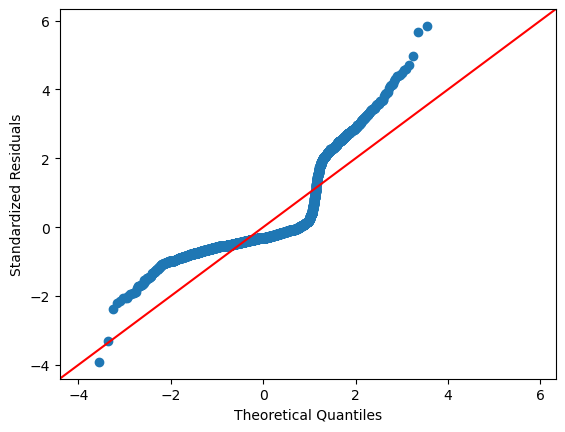

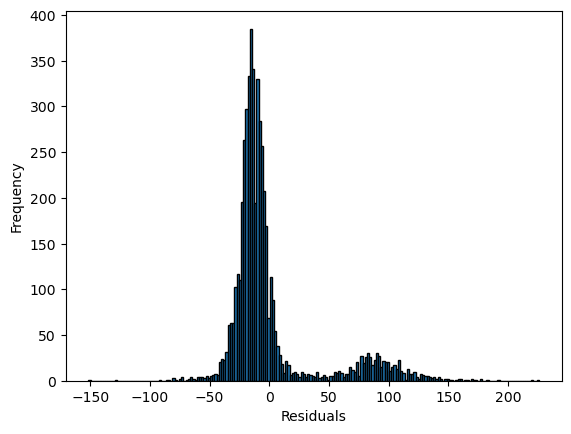

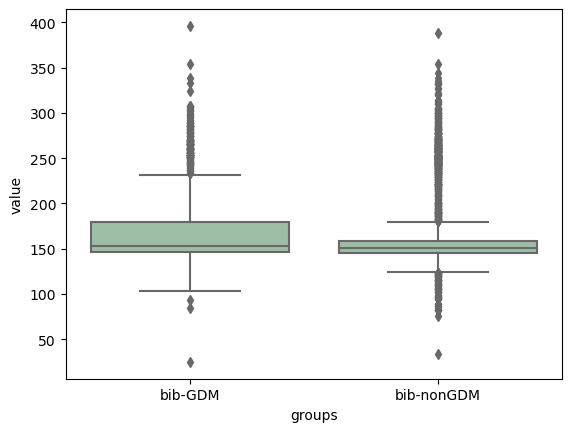

Non-equal variances, Welch's t-test will be performed
2.7354745065769423e-15
minAbdomCirc: significant
RUNNING TESTS FOR varAbdomCirc


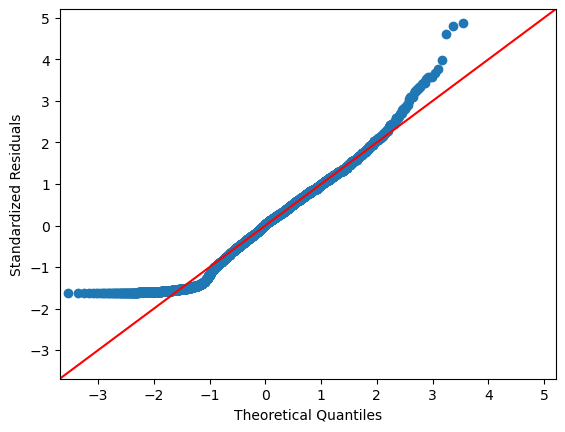

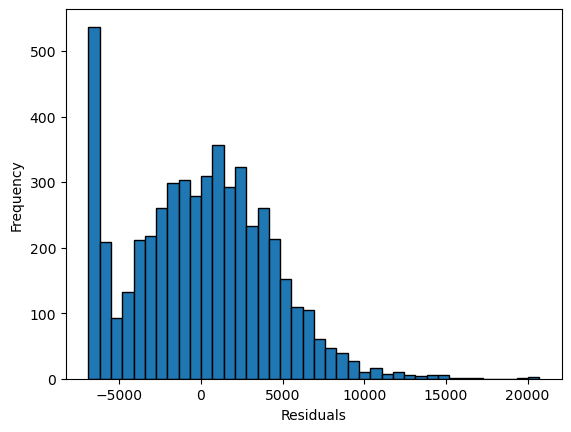

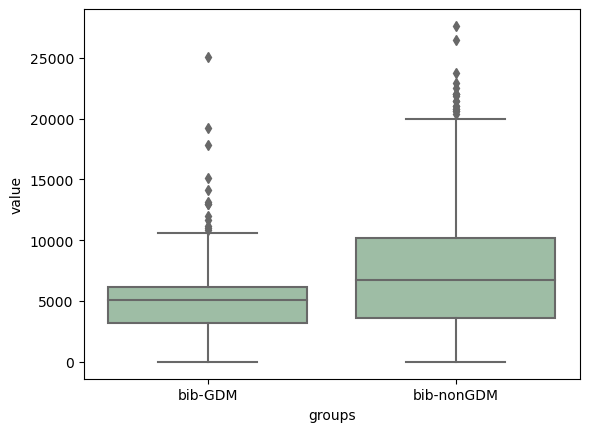

Non-equal variances, Welch's t-test will be performed
3.798452306762345e-71
varAbdomCirc: significant
RUNNING TESTS FOR rangeAbdomCirc


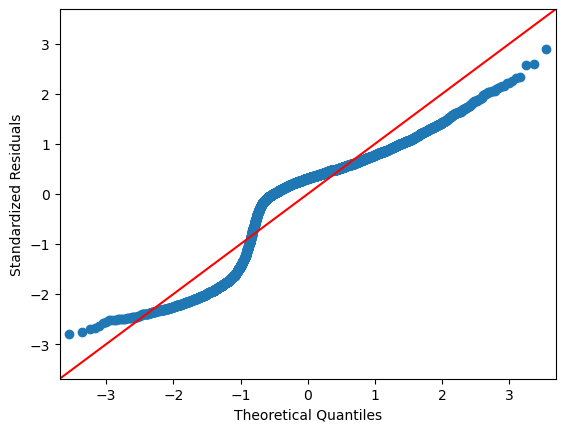

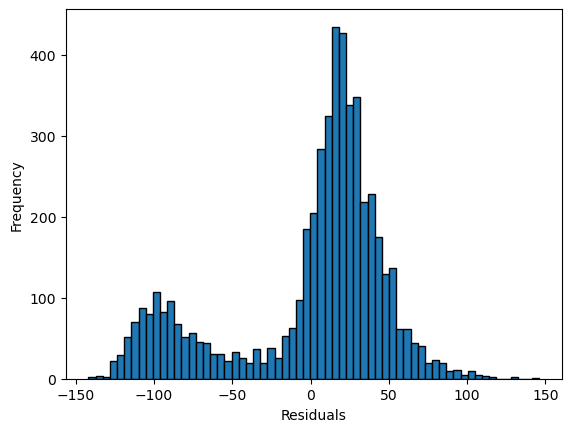

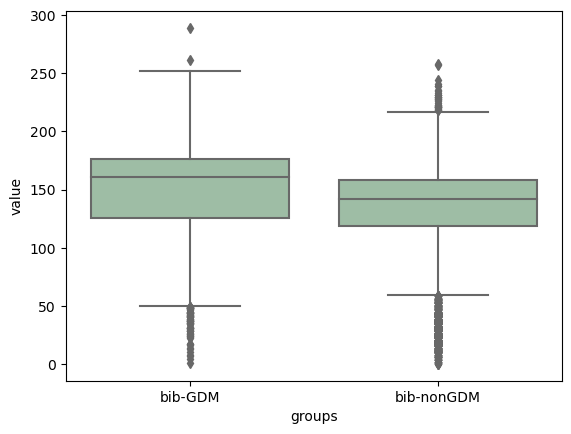

Equal variances, t-test will be performed
1.3198266129671479e-15
rangeAbdomCirc: significant
RUNNING TESTS FOR meanFoetalWeight


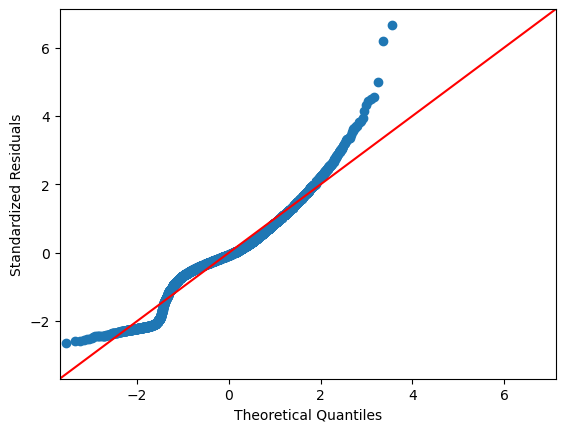

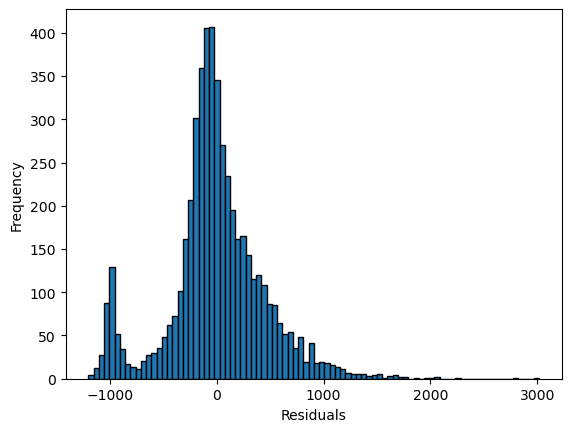

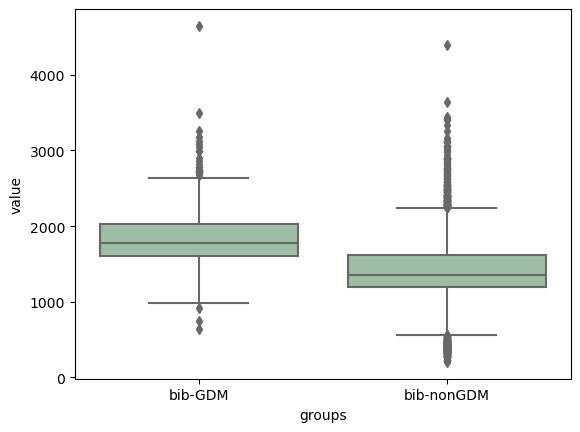

Non-equal variances, Welch's t-test will be performed
5.908451222373392e-159
meanFoetalWeight: significant
RUNNING TESTS FOR maxFoetalWeight


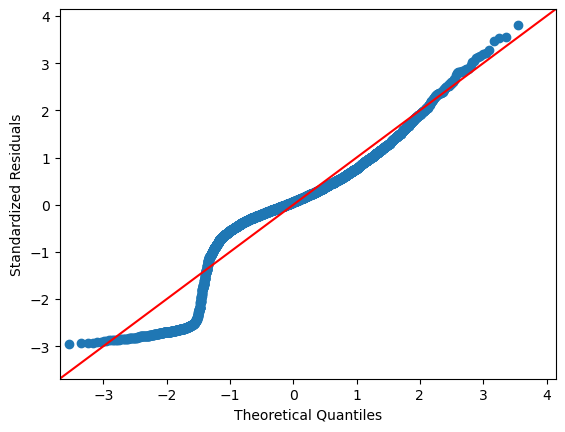

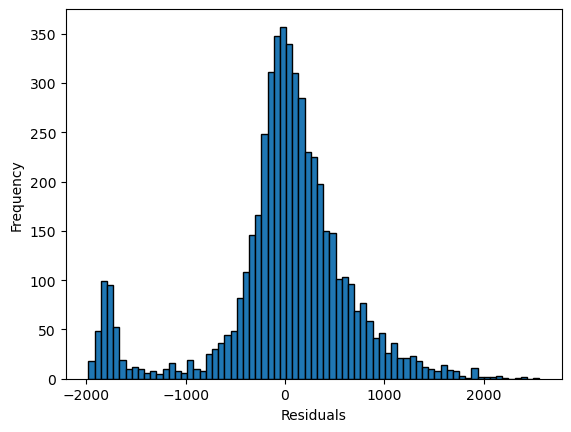

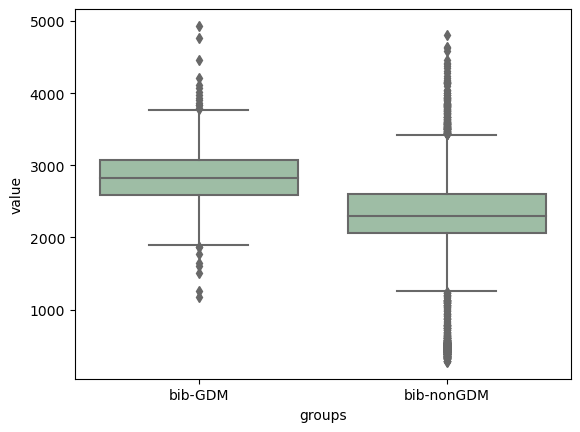

Non-equal variances, Welch's t-test will be performed
3.564190322701893e-181
maxFoetalWeight: significant
RUNNING TESTS FOR minFoetalWeight


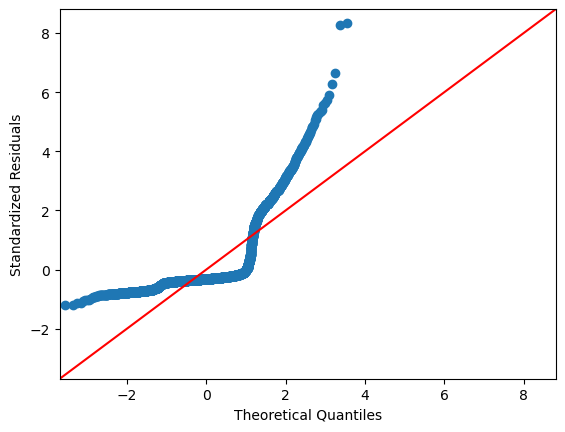

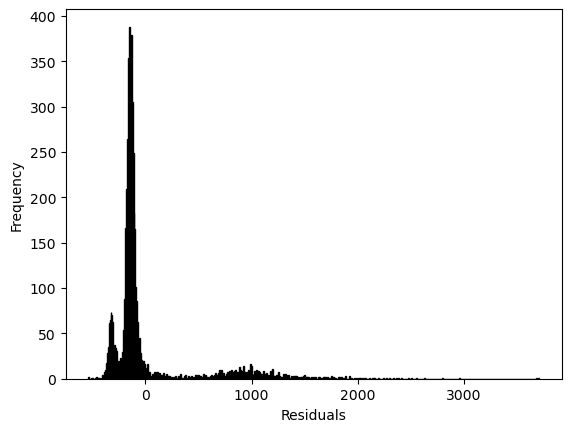

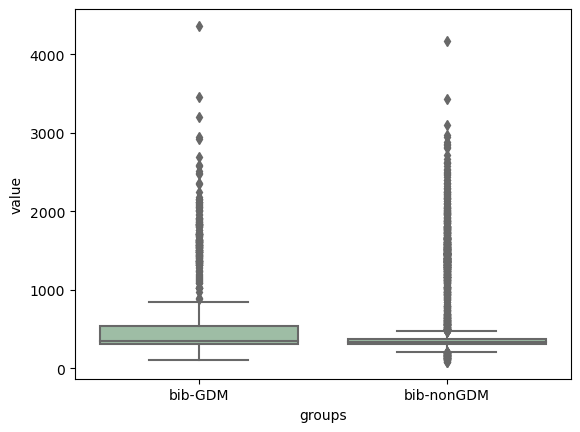

Non-equal variances, Welch's t-test will be performed
2.5733551523597663e-15
minFoetalWeight: significant
RUNNING TESTS FOR varFoetalWeight


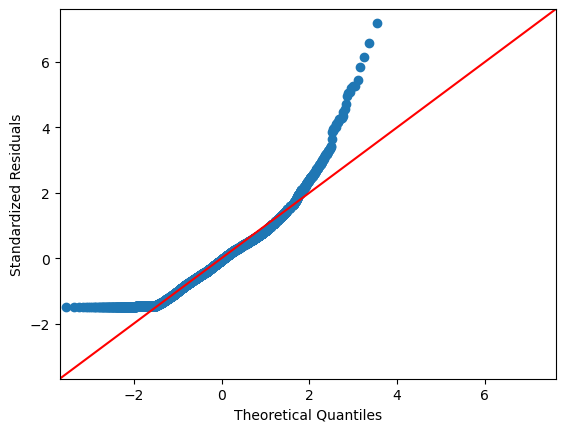

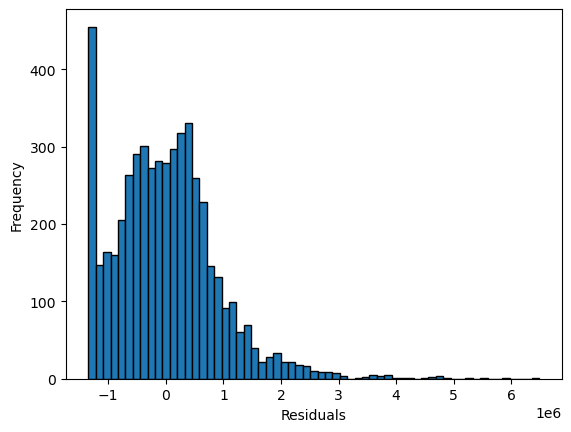

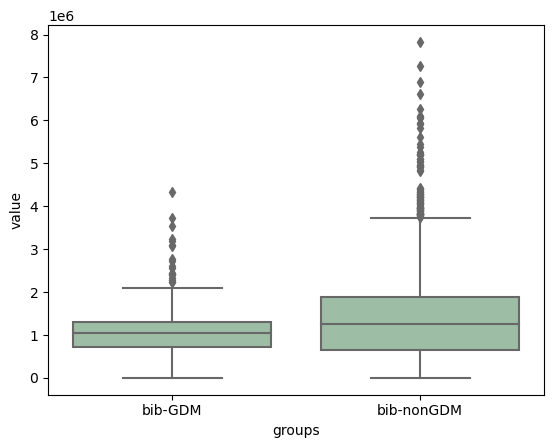

Non-equal variances, Welch's t-test will be performed
1.718966626082297e-37
varFoetalWeight: significant
RUNNING TESTS FOR rangeFoetalWeight


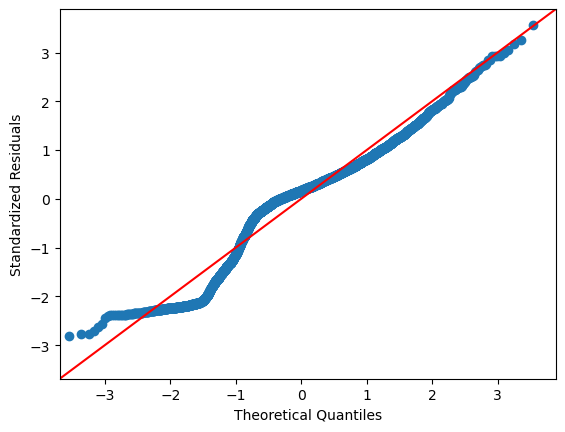

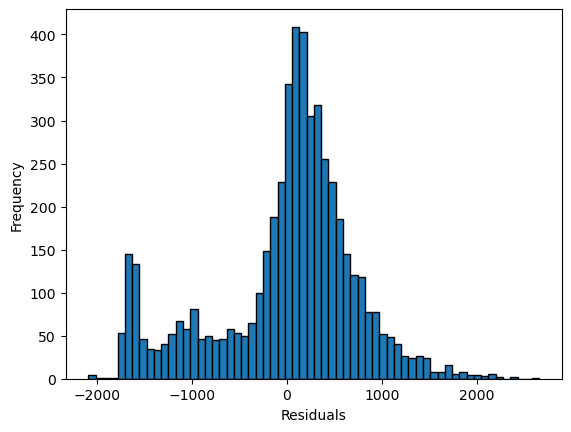

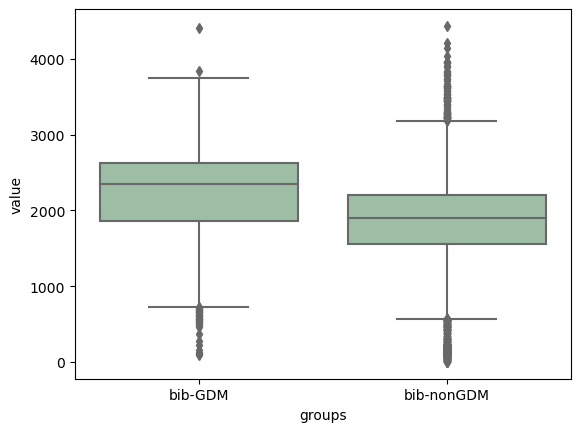

Equal variances, t-test will be performed
1.480505672953571e-44
rangeFoetalWeight: significant


In [137]:
statsPipeline("maternalAge")
# As parity is not a continuous variable, therefore, I do not think test can be performed here
# statsPipeline("parity")
statsPipeline("bookingWeight")
statsPipeline("bookingBMI")
statsPipeline("maternalHeight")
statsPipeline("thirdTrimesterWeight")
statsPipeline("fastingGlucose")
statsPipeline("postGlucose")
statsPipeline("meanAbdomCirc")
statsPipeline("maxAbdomCirc")
statsPipeline("minAbdomCirc")
statsPipeline("varAbdomCirc")
statsPipeline("rangeAbdomCirc")
statsPipeline("meanFoetalWeight")
statsPipeline("maxFoetalWeight")
statsPipeline("minFoetalWeight")
statsPipeline("varFoetalWeight")
statsPipeline("rangeFoetalWeight")